In [1]:
import numpy as np
import pandas as pd 
import os

In [2]:
base_dir = "/kaggle/input/jena-climate"
print(os.listdir(base_dir))

['jena_climate_2009_2016.csv']


In [3]:
fname = os.path.join(base_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [4]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [5]:
print(float_data.shape)

(420451, 14)


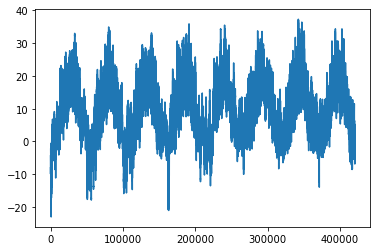

In [6]:
import matplotlib.pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

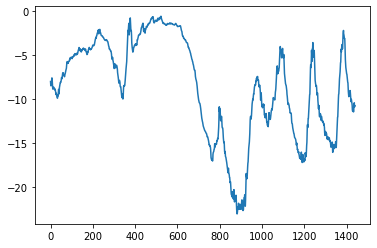

In [7]:
plt.plot(range(1440), temp[:1440])

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index, step=6, batch_size=128, shuffle=False):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + lookback, max_index))
            i += batch_size
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
lookback = 1440
delay = 144
step = 6
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step)

In [11]:
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [12]:
def evaluate_naive_method():
    maes = []
    for step in range(100):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        maes.append(mae)
    print(np.mean(maes))

In [13]:
evaluate_naive_method()

0.2690598901437424


In [14]:
from keras import layers, models
from keras import optimizers

In [15]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=100)


Epoch 1/20
500/500 [==============================] - 22s 43ms/step - loss: 1.3657 - val_loss: 0.6610
Epoch 2/20
500/500 [==============================] - 22s 43ms/step - loss: 0.4730 - val_loss: 0.4863
Epoch 3/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2941 - val_loss: 0.3106
Epoch 4/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2672 - val_loss: 0.3265
Epoch 5/20
500/500 [==============================] - 21s 41ms/step - loss: 0.2551 - val_loss: 0.3262
Epoch 6/20
500/500 [==============================] - 20s 41ms/step - loss: 0.2480 - val_loss: 0.3173
Epoch 7/20
500/500 [==============================] - 21s 41ms/step - loss: 0.2404 - val_loss: 0.2748
Epoch 8/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2340 - val_loss: 0.3530
Epoch 9/20
500/500 [==============================] - 21s 41ms/step - loss: 0.2304 - val_loss: 0.3088
Epoch 10/20
500/500 [==============================] - 21s 42ms/step - loss: 0.226

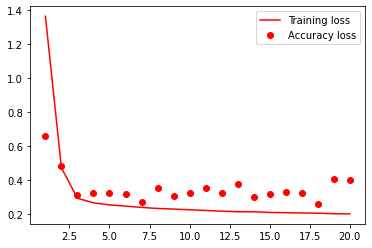

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Accuracy loss')
plt.legend()
plt.show()

In [17]:
model = models.Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=100)

Epoch 1/20
500/500 [==============================] - 23s 46ms/step - loss: 0.3005 - val_loss: 0.2975
Epoch 2/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2834 - val_loss: 0.2407
Epoch 3/20
500/500 [==============================] - 22s 45ms/step - loss: 0.2779 - val_loss: 0.2438
Epoch 4/20
500/500 [==============================] - 23s 45ms/step - loss: 0.2721 - val_loss: 0.2846
Epoch 5/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2677 - val_loss: 0.2652
Epoch 6/20
500/500 [==============================] - 22s 43ms/step - loss: 0.2624 - val_loss: 0.2687
Epoch 7/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2572 - val_loss: 0.2856
Epoch 8/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2523 - val_loss: 0.2834
Epoch 9/20
500/500 [==============================] - 22s 44ms/step - loss: 0.2497 - val_loss: 0.2688
Epoch 10/20
500/500 [==============================] - 23s 45ms/step - loss: 0.244

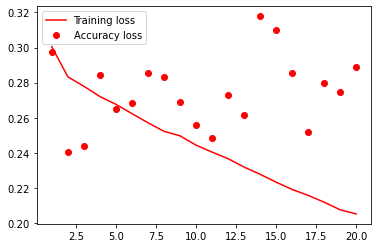

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Accuracy loss')
plt.legend()
plt.show()

In [19]:
model = models.Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=100)

Epoch 1/20
500/500 [==============================] - 357s 714ms/step - loss: 0.3279 - val_loss: 0.2707
Epoch 2/20
500/500 [==============================] - 357s 714ms/step - loss: 0.3051 - val_loss: 0.2902
Epoch 3/20
500/500 [==============================] - 357s 714ms/step - loss: 0.2987 - val_loss: 0.2918
Epoch 4/20
500/500 [==============================] - 357s 714ms/step - loss: 0.2942 - val_loss: 0.2911
Epoch 5/20
500/500 [==============================] - 356s 713ms/step - loss: 0.2899 - val_loss: 0.2389
Epoch 6/20
500/500 [==============================] - 358s 716ms/step - loss: 0.2867 - val_loss: 0.2558
Epoch 7/20
500/500 [==============================] - 357s 714ms/step - loss: 0.2824 - val_loss: 0.2967
Epoch 8/20
500/500 [==============================] - 357s 714ms/step - loss: 0.2774 - val_loss: 0.2765
Epoch 9/20
500/500 [==============================] - 357s 714ms/step - loss: 0.2751 - val_loss: 0.2886
Epoch 10/20
500/500 [==============================] - 357s 714m

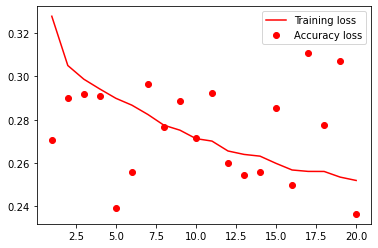

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Accuracy loss')
plt.legend()
plt.show()

In [25]:
model = models.Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, dropout=0.1, recurrent_dropout=0.5, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=10, validation_data=val_gen, validation_steps=100)

Epoch 1/10
500/500 [==============================] - 744s 1s/step - loss: 0.3198 - val_loss: 0.2738
Epoch 2/10
500/500 [==============================] - 744s 1s/step - loss: 0.3018 - val_loss: 0.2588
Epoch 3/10
500/500 [==============================] - 743s 1s/step - loss: 0.2929 - val_loss: 0.2815
Epoch 4/10
500/500 [==============================] - 740s 1s/step - loss: 0.2874 - val_loss: 0.2593
Epoch 5/10
500/500 [==============================] - 743s 1s/step - loss: 0.2800 - val_loss: 0.2865
Epoch 6/10
500/500 [==============================] - 739s 1s/step - loss: 0.2705 - val_loss: 0.2840
Epoch 7/10
500/500 [==============================] - 740s 1s/step - loss: 0.2664 - val_loss: 0.2878
Epoch 8/10
500/500 [==============================] - 739s 1s/step - loss: 0.2639 - val_loss: 0.2474
Epoch 9/10
500/500 [==============================] - 737s 1s/step - loss: 0.2587 - val_loss: 0.2591
Epoch 10/10
500/500 [==============================] - 740s 1s/step - loss: 0.2561 - val_lo

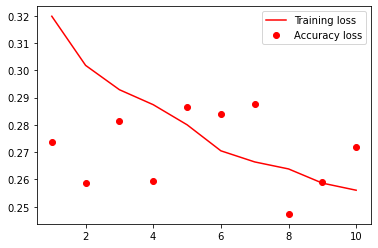

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Accuracy loss')
plt.legend()
plt.show()

In [28]:
model = models.Sequential()
model.add(layers.Bidirectional(layers.GRU(32, input_shape=(None, float_data.shape[-1]))))
model.add(layers.Dense(1))

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=100)

Epoch 1/40
500/500 [==============================] - 26s 51ms/step - loss: 0.2934 - val_loss: 0.2580
Epoch 2/40
500/500 [==============================] - 26s 53ms/step - loss: 0.2739 - val_loss: 0.2723
Epoch 3/40
500/500 [==============================] - 25s 50ms/step - loss: 0.2686 - val_loss: 0.2684
Epoch 4/40
500/500 [==============================] - 25s 51ms/step - loss: 0.2652 - val_loss: 0.3024
Epoch 5/40
500/500 [==============================] - 25s 51ms/step - loss: 0.2580 - val_loss: 0.2603
Epoch 6/40
500/500 [==============================] - 25s 50ms/step - loss: 0.2540 - val_loss: 0.2444
Epoch 7/40
500/500 [==============================] - 26s 52ms/step - loss: 0.2482 - val_loss: 0.2459
Epoch 8/40
500/500 [==============================] - 25s 50ms/step - loss: 0.2402 - val_loss: 0.2795
Epoch 9/40
500/500 [==============================] - 26s 52ms/step - loss: 0.2347 - val_loss: 0.2744
Epoch 10/40
500/500 [==============================] - 25s 51ms/step - loss: 0.227

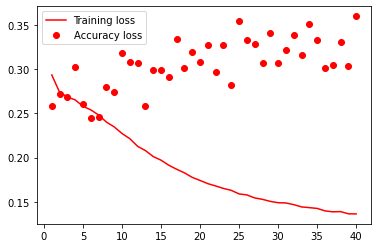

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Accuracy loss')
plt.legend()
plt.show()

In [30]:
model = models.Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

In [31]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(), loss='mae')

In [33]:
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=100)

Epoch 1/20
500/500 [==============================] - 21s 43ms/step - loss: 0.3582 - val_loss: 0.5008
Epoch 2/20
500/500 [==============================] - 22s 44ms/step - loss: 0.3332 - val_loss: 0.5124
Epoch 3/20
500/500 [==============================] - 22s 44ms/step - loss: 0.3167 - val_loss: 0.4704
Epoch 4/20
500/500 [==============================] - 21s 43ms/step - loss: 0.3048 - val_loss: 0.4131
Epoch 5/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2957 - val_loss: 0.4652
Epoch 6/20
500/500 [==============================] - 21s 43ms/step - loss: 0.2877 - val_loss: 0.4584
Epoch 7/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2794 - val_loss: 0.4029
Epoch 8/20
500/500 [==============================] - 23s 46ms/step - loss: 0.2742 - val_loss: 0.4328
Epoch 9/20
500/500 [==============================] - 22s 43ms/step - loss: 0.2675 - val_loss: 0.4700
Epoch 10/20
500/500 [==============================] - 21s 42ms/step - loss: 0.263

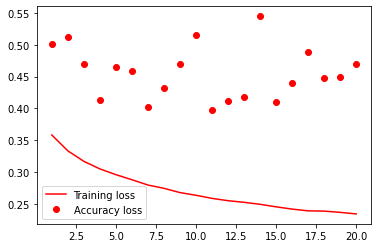

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Accuracy loss')
plt.legend()
plt.show()

In [35]:
step = 3
lookback = 720
delay = 144

In [36]:
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step)

In [37]:
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [38]:
print(val_steps)

775


In [39]:
model = models.Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
 98/500 [====>.........................] - ETA: 58s - loss: 0.3727

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Accuracy loss')
plt.legend()
plt.show()